In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Dependencies

In [272]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset
import cv2
from torchvision import transforms
from PIL import Image,ImageDraw
from torch.utils.data import DataLoader
import torch.nn as nn
import time
from sklearn.model_selection import train_test_split
from torchvision import models
import copy
from tqdm import tqdm
import pickle
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix,accuracy_score,f1_score
from mpl_toolkits.axes_grid1 import ImageGrid


In [3]:
os.chdir("/kaggle/input")

In [4]:
#loading csv file
df = pd.read_csv("./dog-breed-identification/labels.csv")

In [5]:
# according to problem statement
classes_to_predict = ['beagle', 'chihuahua', 'doberman',
'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound',
'tibetan_mastiff']

In [6]:
# No Null values - Good to go.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB
None


In [7]:
pd.set_option('display.max_rows', len(df['breed'].value_counts()))
print(df['breed'].value_counts())
print()
print('total no of classes',df['breed'].value_counts().shape[0])

scottish_deerhound                126
maltese_dog                       117
afghan_hound                      116
entlebucher                       115
bernese_mountain_dog              114
shih-tzu                          112
pomeranian                        111
great_pyrenees                    111
basenji                           110
samoyed                           109
tibetan_terrier                   107
airedale                          107
leonberg                          106
cairn                             106
japanese_spaniel                  105
beagle                            105
miniature_pinscher                102
blenheim_spaniel                  102
australian_terrier                102
irish_wolfhound                   101
lakeland_terrier                   99
saluki                             99
papillon                           96
norwegian_elkhound                 95
whippet                            95
siberian_husky                     95
pug         

In [8]:
filtered_df = df[df['breed'].isin(classes_to_predict)]

In [9]:
print(filtered_df.shape)
print(filtered_df['breed'].value_counts())

(841, 2)
scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64


##### Class Name vs Frequency Bar Plot - it appears uneven distribution of data points - we will take care of it using image auguementation in order to introduce appropriate variance.

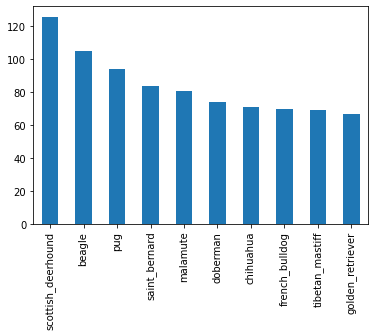

In [10]:
filtered_df['breed'].value_counts().plot(kind='bar')
plt.show()

##### We need to convert breed labels to numerical codes, we could have used label encoder, here is a simpler approach
##### Saving these mapping as pickle file for inference


In [11]:
label_codes = range(filtered_df['breed'].unique().shape[0])
label_names = filtered_df['breed'].unique()

breed_to_code = dict(zip(label_names,label_codes))
code_to_breed = dict(zip(label_codes,label_names))

In [12]:
with open('/kaggle/working/breed_to_code.pkl','wb') as f:
    pickle.dump(breed_to_code,f)
with open('/kaggle/working/code_to_breed.pkl','wb') as f:
    pickle.dump('breed_to_code.pkl',f)
    

In [13]:
# addin Numerical label to df
filtered_df['target'] = [breed_to_code[x] for x in filtered_df['breed']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
filtered_df = filtered_df.reset_index(drop='index')
filtered_df.to_csv("/kaggle/working/filtered_df.csv",index=False)

In [15]:
#splitting into train and test data
train,test = train_test_split(filtered_df,test_size=0.1,random_state=42)

In [16]:
train_df = train.reset_index(drop='index')
train_df.to_csv("/kaggle/working/train_df.csv",index=False)
test_df = test.reset_index(drop='index')
test_df.to_csv("/kaggle/working/test_df.csv",index=False)

In [17]:
# fortunately we have all classes present after splitting the data
print(train_df['breed'].value_counts().shape)

(10,)


In [270]:
import torch
import torchvision
from torch.utils.data import Dataset
import cv2
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import time
from sklearn.model_selection import train_test_split
from torchvision import models
import copy
from tqdm import tqdm

BATCH_SIZE = 16

* ##### preparing custom dataset class, inheriting pytorch's dataset class 

In [19]:
class DogDataset(Dataset):
    
    def __init__(self,csv_file_path,image_dir,transform):
        self.df = pd.read_csv(csv_file_path)
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self,index):
        image_name,breed,label  = self.df.iloc[index]
        
        image_name = image_name + '.jpg'
        image_path = os.path.join(self.image_dir,image_name)
        
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
            
        return (image,label)
        
        
        

### Image Transformer - 
1. Resizing to a comman size and model feedable size 
2. data augumentations - random horizontal flip, rotation, gaussian blur
3. Converting to tensor
4. Resnet's custom normalization using mean and std

In [20]:
data_transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(30),
                        transforms.GaussianBlur(kernel_size=3),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
])

In [21]:
image_dir = '../input/dog-breed-identification/train'
train_csv_file_path = '/kaggle/working/train_df.csv'
test_csv_file_path = '/kaggle/working/test_df.csv'


In [22]:
# Dataset Objects
train_dataset = DogDataset(train_csv_file_path,image_dir,data_transform)
test_dataset = DogDataset(test_csv_file_path,image_dir,data_transform)

In [271]:
# Data Loader Objects
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=True)

### Visualizing Data Loader Output

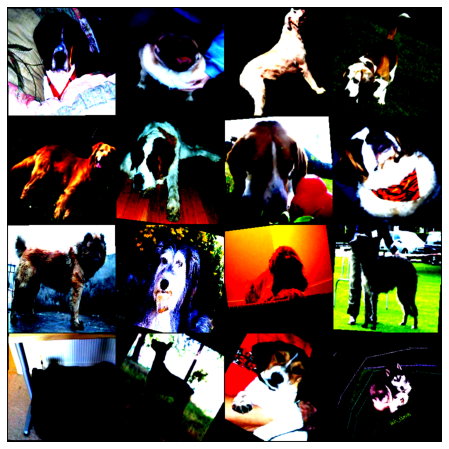

In [24]:

for images,labels in train_loader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images,nrow=4).permute(1,2,0))
    break

In [25]:
# testing data loader
for output in train_loader:
    print(output[0].shape)
    print(output[1])
    break

torch.Size([16, 3, 224, 224])
tensor([1, 2, 5, 9, 1, 8, 5, 1, 6, 7, 9, 4, 1, 4, 1, 1])


In [26]:
def get_device():
    """
    Function to get available devices- GPU if cuda enabled else CPU.
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        
    else:
        device = torch.device('cpu')
    return device

In [27]:
device = get_device()
print(device)

cuda


In [28]:
resnet_model = models.resnet50(pretrained=True)
images, labels = next(iter(train_loader))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [29]:
def test_model(model,image_batch,device):
    """
    Function to test run pretrained model on a set of inputs- here resnet50
    """
    if torch.cuda.is_available():
        model = model.cuda()
        image_batch = image_batch.to(device,non_blocking=True)
    output = model(image_batch)
    print(output.shape)
    return output

In [30]:
test_model(resnet_model,images,device)
#working fine - resnet50 have 1000 imagenet classes, model outputs 1000 scores for each image in batch

torch.Size([16, 1000])


tensor([[ 2.6316,  0.2446, -0.1293,  ...,  0.5993,  2.4095,  3.4495],
        [-3.3107, -2.1925, -2.7807,  ..., -1.1723,  0.4255, -0.1372],
        [ 0.7955,  0.9389, -1.9683,  ..., -1.7753, -0.6620,  3.3657],
        ...,
        [ 0.4847,  0.2229,  0.4801,  ...,  3.7886,  1.0779, -2.1535],
        [-1.7812, -0.1341, -0.2065,  ..., -0.7471,  0.5919,  0.5208],
        [-4.1802, -1.0609, -0.0111,  ..., -1.5506,  1.7479, -0.3561]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [31]:
def eval_model(model, data_loader,loss_func,device):
    """
    Evaluates the given model on validation set in eval mode.
    returns validation loss and validation accuracy for one pass over data.
    """
    model.eval()
    with torch.no_grad():
        running_loss = 0
        running_acc = 0
        for images,labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            _,preds = torch.max(output,1)
            
            loss = loss_func(output,labels)
            running_acc += torch.sum(preds == labels) 
            running_loss += loss.item()*images.size(0)
            
        val_loss = running_loss / len(data_loader.dataset)
        val_acc = running_acc.double() / len(data_loader.dataset)
    return val_loss, val_acc
        
        

In [33]:
def train_model(model,loss_func, optimizer, scheduler,device, num_epochs,output_dir,save_checkpoints=False):
    
    """ Final training function,
    takes pretrained model(loaded), optimzier object, schedular object, 
    device to train on, num_of_epochs, output_dir path to save outputs, and bool value to save checkpts or not
    """
    
    #training parameters
    start_time = time.time()
    # we will create a deepcopy of model weights once best weights are found.
    # deepcopy will help not to interfer with ongoing models state_dict
    best_model_wts = copy.deepcopy(model.state_dict())
    training_loss_hist = []
    val_loss_hist = []
    training_acc_hist = []
    val_acc_hist = []
    best_val_loss = float('inf')
    best_epoch = 0
    max_tolerance = 10
    tolerance = 0
    max_tolerance = 5
    intervals = int(2)


    #trainig loop
    for epoch in range(num_epochs):
      
        print("Epoch {}/{}".format(epoch,num_epochs-1))
        print("-"*10)
    
        #setting model state to train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        batch_num = 0
        #using tdqm to log all the batch metrics
        train_process = tqdm(train_loader)
        for images,labels in train_process:
            images = images.to(device,non_blocking=True)
            labels = labels.to(device,non_blocking=True)

            optimizer.zero_grad()

            outputs = model(images)

            _,preds = torch.max(outputs.data,1)

            loss = loss_func(outputs,labels)


            # backprop initiation and optimizer call
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            batch_acc = torch.sum(preds == labels.data)
            running_corrects += batch_acc
            train_process.set_description(f"Batch {batch_num}. batch_loss: {loss.item()*images.size(0)} batch_acc: {batch_acc}")
            
            batch_num += 1
        
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        
        #performing Cross Validation on Model
        val_loss, val_acc = eval_model(model,test_loader,loss_func,device)
        
        #schedular to decay learning rate
        scheduler.step()
        
        #adding metrics to training history 
        training_loss_hist.append(epoch_loss)
        training_acc_hist.append(epoch_acc)
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        

        print("Training. Loss: {:.4f} Accuracy: {:.4f} ".format(epoch_loss,epoch_acc))
        print("Validation. Loss: {:.4f} Accuracy: {:.4f} ".format(val_loss,val_acc))

        
        # Deepcopy of best model weights so far, based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            tolerance = 0
        else:
            tolerance += 1
        
        #save model checkpoints(weights) after every {intervals} number of epochs
        if save_checkpoints and epoch != 0 and (epoch + 1)% intervals == 0:
            # save the latest weigts
            checkpoints_path  = os.path.join(output_dir,"{}_loss_{:.3f}.pt".format(epoch,val_loss))
            print("Saving Model to ",checkpoints_path)
            checkpoint = {"epoch":epoch,
                            "model": model.state_dict(),
                         "optimizer":optimizer.state_dict()}
            torch.save(checkpoint,checkpoints_path)
        if tolerance >= max_tolerance:
            print("training stopped : Loss no longer decrease. {} is the best validation loss".format(best_epoch))
            break      

                
    time_elapsed = time.time() - start_time
    
    
    #model history object for time series plot of training and val metrics
    history = {'training_loss':training_loss_hist,
                'training_acc':training_acc_hist,
                  'val_loss':val_loss_hist,
                  'val_acc':val_acc_hist}
    model.load_state_dict(best_model_wts)
    print(time_elapsed)
    print("Saving complete model at  '/kaggle/working/complete_model.pt' ")
    torch.save(model,'/kaggle/working/complete_model.pt')
    return model,history

In [34]:
# instantiating pretrained model
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.required_grad = False

In [35]:
# changing models final fully connected layer with our desired layer that will output
# scores for 10 classes only.
no_of_classes = len(classes_to_predict)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,no_of_classes)

In [36]:
if torch.cuda.is_available():
    model = model.cuda()

In [37]:
# using Cross entropy loss and SGD optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(),lr=0.001,momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

In [38]:
dataloader = {'train' : train_loader, 'val' : test_loader}
datasets = {'train': train_dataset,'val':test_dataset}

#### Final Training

In [39]:
final_model,history = train_model(model,loss_func,optimizer,lr_scheduler,device,20,output_dir,True)

  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 0/19
----------


Batch 47. batch_loss: 5.523499011993408 batch_acc: 4: 100%|██████████| 48/48 [00:20<00:00,  2.38it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 1.8148 Accuracy: 0.4405 
Validation. Loss: 1.0928 Accuracy: 0.8706 
Epoch 1/19
----------


Batch 47. batch_loss: 7.213484764099121 batch_acc: 2: 100%|██████████| 48/48 [00:13<00:00,  3.48it/s]  


Training. Loss: 0.8934 Accuracy: 0.8492 
Validation. Loss: 0.6343 Accuracy: 0.9176 
Saving Model to  /kaggle/working/1_loss_0.634.pt


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2/19
----------


Batch 47. batch_loss: 2.2916555404663086 batch_acc: 4: 100%|██████████| 48/48 [00:14<00:00,  3.41it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.6345 Accuracy: 0.8743 
Validation. Loss: 0.5606 Accuracy: 0.8588 
Epoch 3/19
----------


Batch 47. batch_loss: 4.170080661773682 batch_acc: 3: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.4935 Accuracy: 0.9048 
Validation. Loss: 0.4538 Accuracy: 0.8941 
Saving Model to  /kaggle/working/3_loss_0.454.pt
Epoch 4/19
----------


Batch 47. batch_loss: 3.3370795249938965 batch_acc: 3: 100%|██████████| 48/48 [00:13<00:00,  3.52it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.4357 Accuracy: 0.9008 
Validation. Loss: 0.4776 Accuracy: 0.8471 
Epoch 5/19
----------


Batch 47. batch_loss: 1.0740197896957397 batch_acc: 4: 100%|██████████| 48/48 [00:13<00:00,  3.45it/s] 


Training. Loss: 0.3548 Accuracy: 0.9431 
Validation. Loss: 0.3810 Accuracy: 0.8824 
Saving Model to  /kaggle/working/5_loss_0.381.pt


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6/19
----------


Batch 47. batch_loss: 4.6741180419921875 batch_acc: 2: 100%|██████████| 48/48 [00:13<00:00,  3.46it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3444 Accuracy: 0.9286 
Validation. Loss: 0.3772 Accuracy: 0.8941 
Epoch 7/19
----------


Batch 47. batch_loss: 1.6635630130767822 batch_acc: 4: 100%|██████████| 48/48 [00:14<00:00,  3.41it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3075 Accuracy: 0.9325 
Validation. Loss: 0.3650 Accuracy: 0.8824 
Saving Model to  /kaggle/working/7_loss_0.365.pt
Epoch 8/19
----------


Batch 47. batch_loss: 0.8574371337890625 batch_acc: 4: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3248 Accuracy: 0.9312 
Validation. Loss: 0.4126 Accuracy: 0.8588 
Epoch 9/19
----------


Batch 47. batch_loss: 1.672926425933838 batch_acc: 4: 100%|██████████| 48/48 [00:13<00:00,  3.46it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3003 Accuracy: 0.9431 
Validation. Loss: 0.3643 Accuracy: 0.8824 
Saving Model to  /kaggle/working/9_loss_0.364.pt
Epoch 10/19
----------


Batch 47. batch_loss: 4.027069568634033 batch_acc: 2: 100%|██████████| 48/48 [00:13<00:00,  3.49it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3126 Accuracy: 0.9418 
Validation. Loss: 0.4123 Accuracy: 0.8706 
Epoch 11/19
----------


Batch 47. batch_loss: 0.7420399188995361 batch_acc: 4: 100%|██████████| 48/48 [00:13<00:00,  3.43it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3031 Accuracy: 0.9458 
Validation. Loss: 0.3391 Accuracy: 0.9059 
Saving Model to  /kaggle/working/11_loss_0.339.pt
Epoch 12/19
----------


Batch 47. batch_loss: 0.4423230290412903 batch_acc: 4: 100%|██████████| 48/48 [00:13<00:00,  3.52it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3137 Accuracy: 0.9286 
Validation. Loss: 0.3661 Accuracy: 0.9059 
Epoch 13/19
----------


Batch 47. batch_loss: 3.832779884338379 batch_acc: 3: 100%|██████████| 48/48 [00:13<00:00,  3.47it/s]  


Training. Loss: 0.2993 Accuracy: 0.9471 
Validation. Loss: 0.3333 Accuracy: 0.9294 
Saving Model to  /kaggle/working/13_loss_0.333.pt


  0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14/19
----------


Batch 47. batch_loss: 1.343553066253662 batch_acc: 4: 100%|██████████| 48/48 [00:13<00:00,  3.50it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.2976 Accuracy: 0.9392 
Validation. Loss: 0.4376 Accuracy: 0.8588 
Epoch 15/19
----------


Batch 47. batch_loss: 2.0918807983398438 batch_acc: 3: 100%|██████████| 48/48 [00:13<00:00,  3.50it/s] 
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3063 Accuracy: 0.9418 
Validation. Loss: 0.3840 Accuracy: 0.8824 
Saving Model to  /kaggle/working/15_loss_0.384.pt
Epoch 16/19
----------


Batch 47. batch_loss: 6.244277477264404 batch_acc: 2: 100%|██████████| 48/48 [00:13<00:00,  3.50it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3353 Accuracy: 0.9246 
Validation. Loss: 0.3704 Accuracy: 0.8941 
Epoch 17/19
----------


Batch 47. batch_loss: 2.890298366546631 batch_acc: 3: 100%|██████████| 48/48 [00:13<00:00,  3.57it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.2994 Accuracy: 0.9431 
Validation. Loss: 0.2904 Accuracy: 0.9412 
Saving Model to  /kaggle/working/17_loss_0.290.pt
Epoch 18/19
----------


Batch 47. batch_loss: 1.752057433128357 batch_acc: 4: 100%|██████████| 48/48 [00:14<00:00,  3.39it/s]  
  0%|          | 0/48 [00:00<?, ?it/s]

Training. Loss: 0.3291 Accuracy: 0.9312 
Validation. Loss: 0.3662 Accuracy: 0.9059 
Epoch 19/19
----------


Batch 47. batch_loss: 2.639575958251953 batch_acc: 4: 100%|██████████| 48/48 [00:13<00:00,  3.54it/s]  


Training. Loss: 0.2976 Accuracy: 0.9458 
Validation. Loss: 0.3728 Accuracy: 0.8941 
Saving Model to  /kaggle/working/19_loss_0.373.pt
309.66793155670166
Saving complete model at  '/kaggle/working/complete_model.pt' 


#### Plotting training loss and accuracy

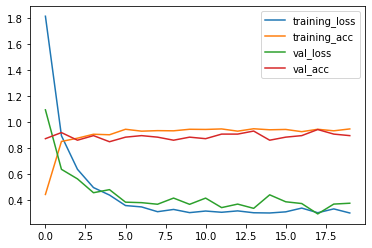

In [274]:
for key,val in history.items():
    plt.plot(val,label=key)
plt.legend()
plt.show()

#### Running Inference on Test Instances to calculate performance metrics

In [235]:
predictions = []
true_labels = []
for images,labels in test_loader:
    images = images.to(device,non_blocking=True)
    labels = labels.to(device,non_blocking=True)
    output = final_model(images)    
    preds = torch.max(output,1)[1]
    predictions += list(preds.cpu().numpy())
    true_labels += list(labels.cpu().numpy())
    
    accuracy = torch.sum(preds == labels) / images.size(0)
    print(accuracy)
    

tensor(0.8125, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(0.8750, device='cuda:0')
tensor(0.8125, device='cuda:0')
tensor(1., device='cuda:0')
tensor(1., device='cuda:0')


#### Performance Metrics

In [258]:
calc_accuracy_score = accuracy_score(true_labels,predictions)
calc_f1_score = f1_score(true_labels,predictions,average='weighted')
calc_confusion_matrix = confusion_matrix(true_labels,predictions)
calc_class_report = classification_report(true_labels,predictions,target_names=breed_to_code.keys())
# roc_score = roc_auc_score(true_labels,predictions,multi_class='ovr',average='macro')

In [275]:
print("Metrics: Calculated over test split of data")
print()
print("Accuracy Score: ",calc_accuracy_score)
print()
print("F1 Score: ",calc_f1_score)
print()
print("Confusion_matrix")
print(calc_confusion_matrix)
print()
print("CLASSIFICATION REPORT")

print(calc_class_report)

Metrics: Calculated over test split of data

Accuracy Score:  0.8705882352941177

F1 Score:  0.871392974414646

Confusion_matrix
[[ 7  0  0  0  1  0  0  0  0  0]
 [ 0 10  0  0  0  1  0  0  0  0]
 [ 0  1  9  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0]
 [ 0  1  0  0  6  0  0  0  1  0]
 [ 0  0  0  0  1  5  0  0  1  0]
 [ 0  0  0  0  0  0 12  1  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  2  0]
 [ 1  1  0  0  0  1  0  0  0  4]]

CLASSIFICATION REPORT
                    precision    recall  f1-score   support

  golden_retriever       0.88      0.88      0.88         8
scottish_deerhound       0.77      0.91      0.83        11
          doberman       1.00      0.90      0.95        10
          malamute       1.00      1.00      1.00         9
         chihuahua       0.75      0.75      0.75         8
               pug       0.71      0.71      0.71         7
     saint_bernard       1.00      0.92      0.96        13
            beagle       0.91      1

In [59]:
def denormalize_image(image_tensor):
    """Denormalizes the image to original state."""
    image_tensor = image_tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image_tensor = std * image_tensor + mean
    return image_tensor

In [56]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for images, labels in dataloders:
        if torch.cuda.is_available():
            images, labels = images.to(device), labels.to(device)
       

        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       
        
        images = images.cpu()
        for j in range(images.size()[0]):
            ax = grid[cnt]
            
            ax.imshow(denormalize_image(images.data[j]))
#             
            ax.text(10, 210, '{}/{}'.format(code_to_breed[int(preds[j].cpu())], code_to_breed[int(labels.data[j].cpu())]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

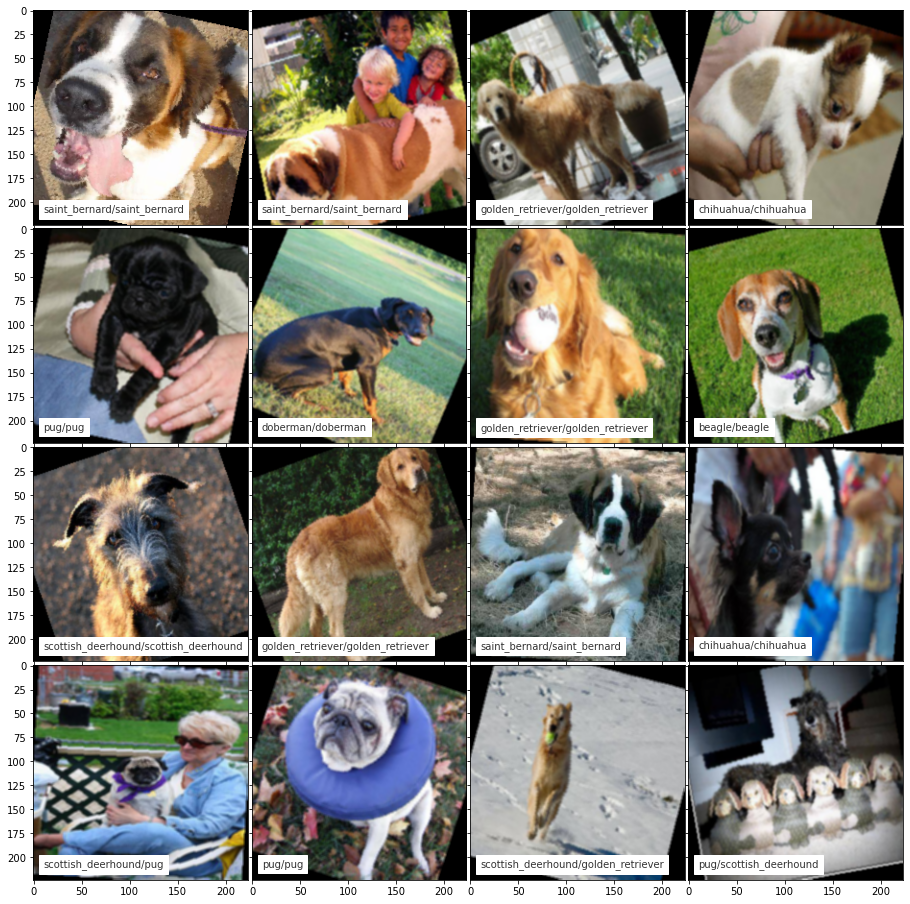

In [61]:
visualize_model(test_loader,final_model)

In [84]:
# Transformation that needs to applied for inference
inference_transformer = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])
])

In [276]:
# loading saved model
model = torch.load('/kaggle/working/complete_model.pt')

In [277]:
def run_inference(model,image_path,inference_transformer,code_to_breed,show_image=True):
    model.eval()
    image = Image.open(image_path)
    transformed_image = inference_transformer(image)
    
    if torch.cuda.is_available():
        model = model.cuda()
        transformed_image = transformed_image.cuda()
        
    transformed_image = transformed_image.unsqueeze(0)
    output = model(transformed_image).cpu()
    score,pred = torch.max(output,1)
    if show_image:
        image = np.array(image)
#         image = cv2.putText(image, code_to_breed[int(pred.cpu())], (10, 30) , cv2.FONT_HERSHEY_SIMPLEX ,  
#                    1, (255, 255, 255) , 3, cv2.LINE_AA) 
        plt.title("Breed: "+code_to_breed[int(pred.cpu())])
    
        plt.imshow(image)
    return pred,code_to_breed[int(pred.cpu())],score.data


(tensor([8]), 'french_bulldog', tensor([3.3934]))


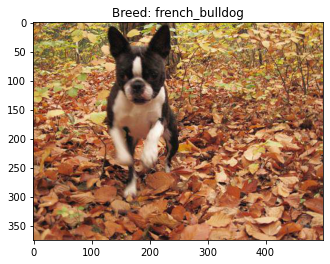

In [278]:
output = run_inference(model,'../input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',inference_transformer,code_to_breed)
print(output)